# Covid-Net Hospitalization Data EDA

Goals:
* Understand all the columns and type
* Get regional hospitalization time series and plot it with bar chart (try interactive country plotly later)

Dataset Schema:
* Catchment - Where the cases were recorded initially
* Network - The networks are the COVID-19-Associated Hospitalization Surveillance Network (COVID-NET) (EIP and IHSP surveillance networks combined),
Emerging Infections Program (EIP) only, and Influenza Hospitalization Surveillance Project (IHSP) only
* MMWR-WEEK - The weeks are assigned according to the calendar date on which the week ends. Range from 1-53, although most years consist of 52 weeks. 2020 Week 10 ends at March 7 Saturday, 2020.

In [111]:
import re
import datetime
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 100)
plt.style.use('Solarize_Light2')

## Load Data


In [112]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hacklytics-2021/COVID-19Surveillance_All_Data.csv')
data.head()

,CATCHMENT,NETWORK,YEAR,MMWR-YEAR,MMWR-WEEK,AGE CATEGORY,SEX,RACE,CUMULATIVE RATE,WEEKLY RATE
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1
1,Utah,IHSP,2020,2020,10,Overall,Overall,White,0.0,0.0
2,Utah,IHSP,2020,2020,10,Overall,Overall,Black,0.0,0.0
3,Utah,IHSP,2020,2020,10,Overall,Overall,Hispanic/Latino,0.0,0.0
4,Utah,IHSP,2020,2020,10,Overall,Overall,Asian/Pacific Islander,0.0,0.0


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34272 entries, 0 to 34271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CATCHMENT        34272 non-null  object 
 1   NETWORK          34272 non-null  object 
 2   YEAR             34272 non-null  int64  
 3   MMWR-YEAR        34272 non-null  int64  
 4   MMWR-WEEK        34272 non-null  int64  
 5   AGE CATEGORY     34272 non-null  object 
 6   SEX              34272 non-null  object 
 7   RACE             34272 non-null  object 
 8   CUMULATIVE RATE  17136 non-null  float64
 9   WEEKLY RATE      17136 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.6+ MB


In [114]:
population_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hacklytics-2021/US_Census/nst-est2020.csv')
population_df.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,10,0,0,0,United States,308745538,308758105,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123
1,20,1,0,0,Northeast Region,55317240,55318414,55380764,55608318,55782661,55912775,56021339,56052790,56063777,56083383,56084543,56002934,55849869
2,20,2,0,0,Midwest Region,66927001,66929737,66975328,67164092,67348275,67576524,67765576,67885682,68018175,68160342,68263019,68340091,68316744
3,20,3,0,0,South Region,114555744,114563042,114869421,116019483,117264196,118397213,119666248,121049223,122419547,123611036,124649156,125686544,126662754
4,20,4,0,0,West Region,71945553,71946912,72101630,72791588,73482530,74173435,74933166,75751299,76570256,77267367,77841481,78300384,78654756


## Preprocessing (population data)

For `population_df` we're only interested in 2020 estimated population and the 10 states tracked by COVID-NET hospitalization newwork. Let's do some filtering first.

In [115]:
# convert all col names to lower case and replace non-alphebetical with _
def rename_df_col(df):
    schema = df.columns
    mapper = {}
    for i in range(len(schema)):
        # strip extra white spaces and to lower case
        label = schema[i].strip().lower()
        # replace all non-alphebetic characters with '_'
        label = re.sub('[^0-9a-zA-Z]+', '_', label)
        mapper[schema[i]] = label
    
    return df.rename(columns=mapper)


In [116]:
# preprocess col names to lower
population_df = rename_df_col(population_df)
population_df.head(1)

,sumlev,region,division,state,name,census2010pop,estimatesbase2010,popestimate2010,popestimate2011,popestimate2012,popestimate2013,popestimate2014,popestimate2015,popestimate2016,popestimate2017,popestimate2018,popestimate2019,popestimate2020
0,10,0,0,0,United States,308745538,308758105,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123


Filter for only states, country= Unitied States, and 2020 estimated population.

In [117]:
population_df = population_df[['state', 'name', 'popestimate2020']]
hosp_states = ["Tennessee","Utah","California","Colorado","Connecticut","Georgia","Iowa","Maryland","Michigan","Minnesota","New Mexico","New York","Ohio","Oregon"]

state_pop_df = population_df.loc[population_df['name'].isin(hosp_states)]
state_pop_df.head()

,state,name,popestimate2020
9,6,California,39368078
10,8,Colorado,5807719
11,9,Connecticut,3557006
15,13,Georgia,10710017
20,19,Iowa,3163561


## Preprocessing (hospitalization data)

### Renaming DF Column Labels

In [118]:
# preprocess column labels and rename the data dataframe
data = rename_df_col(data)
data.head(1)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1


### Convert and add datetime col

We will convert `mmwr_year` and `mmwr_week` to actual datetime obejct and
put it as another column called `date`.

In [119]:
# concat mmwr_year and mmwr_week together as a new column <yyyyww>
data['date'] = data['mmwr_year'].astype(str) + (data['mmwr_week'] -1).astype(str)

# convert date col to a real datetime object
data['date'] = pd.to_datetime(data['date'] +'6', format='%Y%W%w')
data.head(1)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07


Now have all the dates. Check NULL to further investigate.

In [120]:
# Checkout null rows and see the record classification
null_rows = data[pd.isnull(data['weekly_rate'])]
null_rows.head(12)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
6528,Tennessee,EIP,2020,2021,5,Overall,Male,Overall,NaN,NaN,2021-01-30
6529,Tennessee,EIP,2020,2021,5,Overall,Overall,American Indian/Alaska Native,NaN,NaN,2021-01-30
6530,Tennessee,EIP,2020,2021,5,Overall,Female,Overall,NaN,NaN,2021-01-30
6531,Tennessee,EIP,2020,2021,5,Overall,Overall,Overall,NaN,NaN,2021-01-30
6532,Utah,IHSP,2020,2021,5,Overall,Overall,White,NaN,NaN,2021-01-30
6533,Utah,IHSP,2020,2021,5,Overall,Overall,Black,NaN,NaN,2021-01-30
6534,Utah,IHSP,2020,2021,5,Overall,Overall,Hispanic/Latino,NaN,NaN,2021-01-30
6535,Utah,IHSP,2020,2021,5,Overall,Overall,Asian/Pacific Islander,NaN,NaN,2021-01-30
6536,Utah,IHSP,2020,2021,5,Overall,Overall,American Indian/Alaska Native,NaN,NaN,2021-01-30
6537,Utah,IHSP,2020,2021,5,Overall,Male,Overall,NaN,NaN,2021-01-30


The NaN rows are consistent in the sense of cumulative_rate  and weekly_rate is
Nan at iff at the same time. The last valid recorded rate pairs are `mmwr_year
=2021` and `mmwr_week = 4`. Each week for each catchment state is recorded
using 8 row entries for classification.

* We will get rid of the unrecorded rows first and try to plot the **overall 
hospitalization rate for California** and then all states.

### Join Confirmed/Death/Recovered Cases Info

Now need to join the additional information based on `catchment` and `date` keys. First let's only reserve useful columns (`catchment`, `date`, and CDR info).

In [143]:
cdr_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hacklytics-2021/merged_data.csv')

# keep only useful columns that we want to join to data
cdr_df = cdr_df[['catchment', 'date', 'Confirmed', 'Deaths', 'Recovered']]
cdr_df.head()

,catchment,date,Confirmed,Deaths,Recovered
0,California,2020-03-07,NaN,NaN,NaN
1,California,2020-03-07,NaN,NaN,NaN
2,California,2020-03-07,NaN,NaN,NaN
3,California,2020-03-07,NaN,NaN,NaN
4,California,2020-03-07,NaN,NaN,NaN


In [156]:
# Now do data left join cdr_df
cdr_df['date'] = pd.to_datetime(cdr_df['date'], format='%Y-%m-%d')
cdr_df.shape

(8736, 5)

### Separting row classifications

In [121]:
# filter for all the valid rows for states (exclude 'Entire Network')
valid_df = data[pd.notnull(data['weekly_rate'])]
valid_df = valid_df.loc[valid_df['catchment'] != 'Entire Network']

# filter for all overall rows for states exclude entire network)
overall_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] == 'Overall')]

# filter based on sex for states
sex_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] != 'Overall') &
                          (valid_df['race'] == 'Overall')]


# filter based on race for states
race_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] != 'Overall')]


# filter based on age
age_df = valid_df.loc[(valid_df['age_category'] != 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] == 'Overall')]


# geeralize to five age group as it's shown on the website
age_df = age_df.loc[(age_df['age_category'] == '0-4 yr') |
                    (age_df['age_category'] == '5-17 yr') |
                    (age_df['age_category'] == '18-49 yr') |
                    (age_df['age_category'] == '50-64 yr') |
                    (age_df['age_category'] == '65+ yr')]

print(f'shape of rows with valid rate: {valid_df.shape}')
print(f'shape of overall_df: {overall_df.shape}')
print(f'shape of sex_df: {sex_df.shape}')
print(f'shape of race_df: {race_df.shape}')
print(f'shape of age_df: {age_df.shape}')

shape of rows with valid rate: (14112, 11)
shape of overall_df: (672, 11)
shape of sex_df: (1344, 11)
shape of race_df: (3360, 11)
shape of age_df: (3360, 11)


In [157]:
# save it as csv
valid_df.to_csv('valid_df.csv', index=False)
print('valid_df shape: ', valid_df.shape)

# check on states that have hospitalization tracking
states= overall_df['catchment'].unique()
print(states)
print(len(states))

valid_df shape:  (14112, 11)
['Tennessee' 'Utah' 'California' 'Colorado' 'Connecticut' 'Georgia' 'Iowa'
 'Maryland' 'Michigan' 'Minnesota' 'New Mexico' 'New York' 'Ohio' 'Oregon']
14


### Join Overall DF with State Pop DF

We'll now do a left join on valid_df with state_pop_df so we can 
have populations with each states. [link text](https://)The next step would be to approximate the actual hospitalization count using the population and the rate.

The formula would be: 

$hospitalization\ count = \frac{total\ population}{100000} * rate$

In [123]:
# Left join (using merger)
overall_df = overall_df.merge(state_pop_df, left_on='catchment', right_on='name')

# Then drop useless columns
overall_df = overall_df.drop(labels=['network', 'name', 'state'], axis=1)


In [133]:
print(overall_df.shape)
overall_df.head()

(672, 11)


,catchment,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date,popestimate2020
0,Tennessee,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07,6886834
1,Tennessee,2020,2020,11,Overall,Overall,Overall,0.7,0.6,2020-03-14,6886834
2,Tennessee,2020,2020,12,Overall,Overall,Overall,3.2,2.5,2020-03-21,6886834
3,Tennessee,2020,2020,13,Overall,Overall,Overall,11.4,8.2,2020-03-28,6886834
4,Tennessee,2020,2020,14,Overall,Overall,Overall,20.4,8.9,2020-04-04,6886834


### Compute Hos Count

We would then calculate the hospitalization count approximation.
First compute cumulative hospitalization count based on the formula, then convert it to ceiling int.


In [170]:
overall_df = overall_df.assign(cumuhos_count = np.ceil(overall_df['popestimate2020']/1e6 * overall_df['cumulative_rate']).astype(int))
overall_df = overall_df.assign(weeklyhos_count = np.ceil(overall_df['popestimate2020']/1e6 * overall_df['weekly_rate']).astype(int))

print(overall_df.shape)
overall_df.head()

(672, 13)


,catchment,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date,popestimate2020,cumuhos_count,weeklyhos_count
0,Tennessee,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07,6886834,1,1
1,Tennessee,2020,2020,11,Overall,Overall,Overall,0.7,0.6,2020-03-14,6886834,5,5
2,Tennessee,2020,2020,12,Overall,Overall,Overall,3.2,2.5,2020-03-21,6886834,23,18
3,Tennessee,2020,2020,13,Overall,Overall,Overall,11.4,8.2,2020-03-28,6886834,79,57
4,Tennessee,2020,2020,14,Overall,Overall,Overall,20.4,8.9,2020-04-04,6886834,141,62


### Join with CDR info

In [174]:
# do a left join and drop all the duplicated rows 
overall_df = pd.merge(overall_df, cdr_df, on=['catchment', 'date'], how='left')
overall_df = joined.drop_duplicates()

# see how we did
print(overall_df.shape)
overall_df.head()

(672, 16)


,catchment,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date,popestimate2020,cumuhos_count,weeklyhos_count,Confirmed,Deaths,Recovered
0,Tennessee,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07,6886834,1,1,NaN,NaN,NaN
13,Tennessee,2020,2020,11,Overall,Overall,Overall,0.7,0.6,2020-03-14,6886834,5,5,NaN,NaN,NaN
26,Tennessee,2020,2020,12,Overall,Overall,Overall,3.2,2.5,2020-03-21,6886834,23,18,131.0,0.0,0.0
39,Tennessee,2020,2020,13,Overall,Overall,Overall,11.4,8.2,2020-03-28,6886834,79,57,1468.0,3.0,0.0
52,Tennessee,2020,2020,14,Overall,Overall,Overall,20.4,8.9,2020-04-04,6886834,141,62,7948.0,31.0,0.0


## Visualization

To answer question: How is hospitalization count comparing with the total
confirmed cases? And does higher hospitalization count or ratio per confirmed 
case helps with recovery?

The things we need to know:
* Plot hospitalization count to confirmed cases ratio. The formula that we used is shown below:
$$hosCount\ per\ confirmed = \frac{cumulative\ hosCount}{confirmed\ cases}$$

* Plot recovery_per_confirmed plots

In [191]:
# compute two new columns for plotting
overall_df = overall_df.assign(hoscount_per_confirmed = overall_df['cumuhos_count']/overall_df['Confirmed'])
overall_df = overall_df.assign(recovery_per_confirmed = overall_df['Recovered']/overall_df['Confirmed'])
overall_df = overall_df.assign(infecting_ratio = overall_df['Confirmed']/overall_df['popestimate2020'])

print(overall_df.shape)
overall_df.tail()

(672, 19)


,catchment,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date,popestimate2020,cumuhos_count,weeklyhos_count,Confirmed,Deaths,Recovered,hoscount_per_confirmed,recovery_per_confirmed,infecting_ratio
9009,Oregon,2020,2020,53,Overall,Overall,Overall,159.2,6.2,2021-01-02,4241507,676,27,746491.0,9811.0,0.0,0.000906,0.0,0.175997
9035,Oregon,2020,2021,1,Overall,Overall,Overall,164.6,5.3,2021-01-02,4241507,699,23,746491.0,9811.0,0.0,0.000936,0.0,0.175997
9061,Oregon,2020,2021,2,Overall,Overall,Overall,168.4,3.8,2021-01-09,4241507,715,17,795943.0,10296.0,0.0,0.000898,0.0,0.187656
9074,Oregon,2020,2021,3,Overall,Overall,Overall,172.0,3.7,2021-01-16,4241507,730,16,852255.0,10964.0,0.0,0.000857,0.0,0.200932
9087,Oregon,2020,2021,4,Overall,Overall,Overall,174.1,2.1,2021-01-23,4241507,739,9,910617.0,12082.0,0.0,0.000812,0.0,0.214692


Plot hospitalization count to confirmed cases ratio per state.

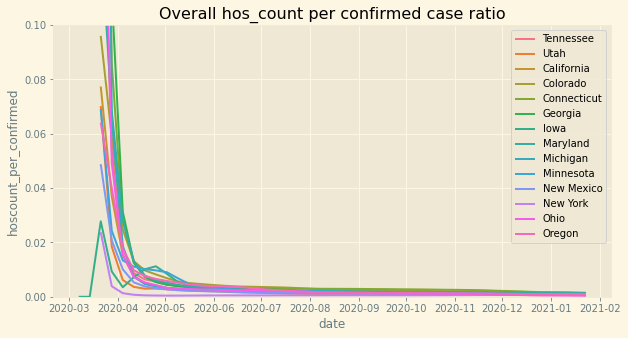

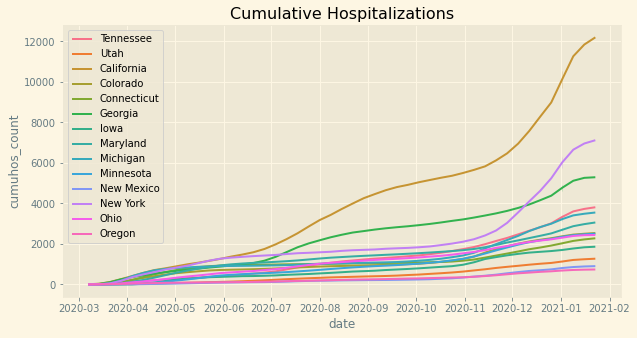

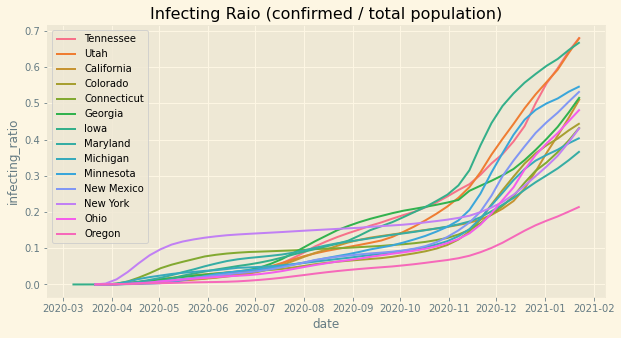

In [193]:
plt.figure(figsize=(10,5))
plt.title('Overall hos_count per confirmed case ratio')
plt.ylim(0, 0.1)
sns.lineplot(data=overall_df, x='date', y='hoscount_per_confirmed', hue='catchment')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,5))
plt.title('Cumulative Hospitalizations')
sns.lineplot(data=overall_df, x='date', y='cumuhos_count', hue='catchment')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,5))
plt.title('Infecting Raio (confirmed / total population)')
sns.lineplot(data=overall_df, x='date', y='infecting_ratio', hue='catchment')
plt.legend(loc='best')
plt.show()


### Overall hospitalization rate

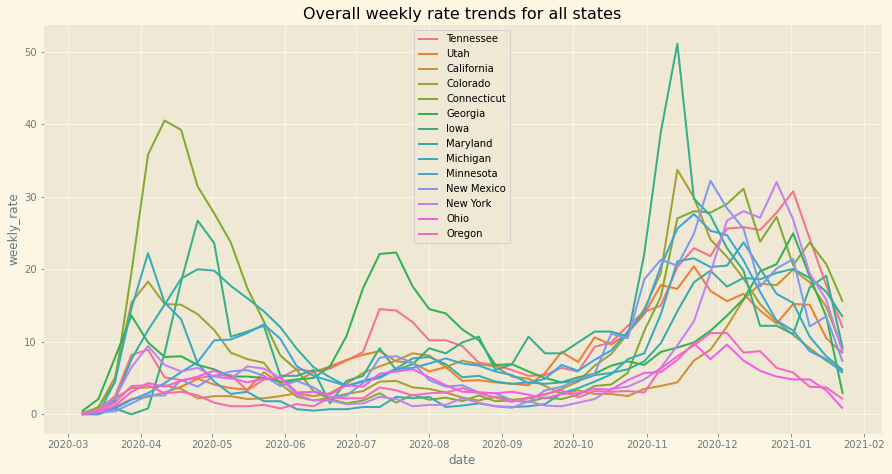

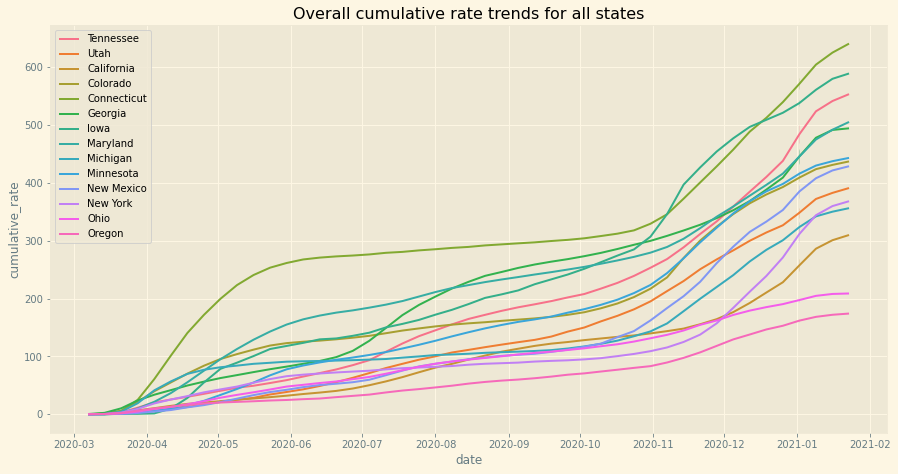

In [141]:
states_overall_df = overall_df.loc[overall_df['catchment'] != 'Entire Network']
plt.figure(figsize=(15,7.5))
plt.title('Overall weekly rate trends for all states')
sns.lineplot(data=states_overall_df, x='date', y='weekly_rate', hue='catchment')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,7.5))
plt.title('Overall cumulative rate trends for all states')
sns.lineplot(data=states_overall_df, x='date', y='cumulative_rate', hue='catchment')
plt.legend(loc='best')
plt.show()

### Hospitalization rate (based on gender)

**Todo**: exclude "Entire Network" in the "catchment" col and plot the gender rate curve using subplots state wise.

In [126]:
sex_df.head()

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
6,Utah,IHSP,2020,2020,10,Overall,Male,Overall,0.0,0.0,2020-03-07
7,Utah,IHSP,2020,2020,10,Overall,Female,Overall,0.0,0.0,2020-03-07
8,Tennessee,EIP,2020,2020,10,Overall,Male,Overall,0.0,0.0,2020-03-07
9,Tennessee,EIP,2020,2020,10,Overall,Female,Overall,0.1,0.1,2020-03-07
16,California,EIP,2020,2020,10,Overall,Male,Overall,0.1,0.1,2020-03-07


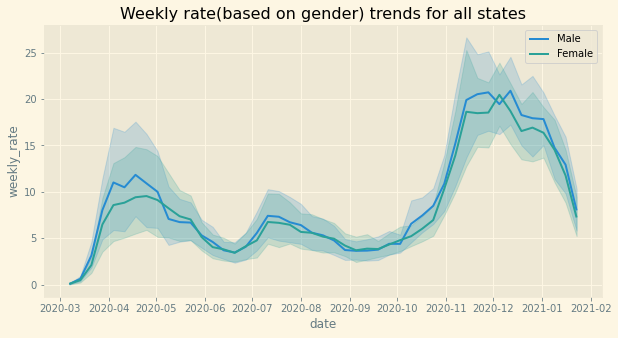

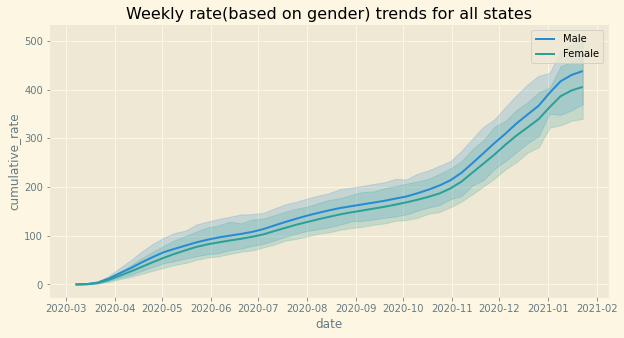

In [127]:
plt.figure(figsize=(10,5))
plt.title('Weekly rate(based on gender) trends for all states')
sns.lineplot(data=sex_df, x='date', y='weekly_rate', hue='sex')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(10,5))
plt.title('Weekly rate(based on gender) trends for all states')
sns.lineplot(data=sex_df, x='date', y='cumulative_rate', hue='sex')
plt.legend(loc='best')
plt.show()

### Hospitalization rate (based on race)

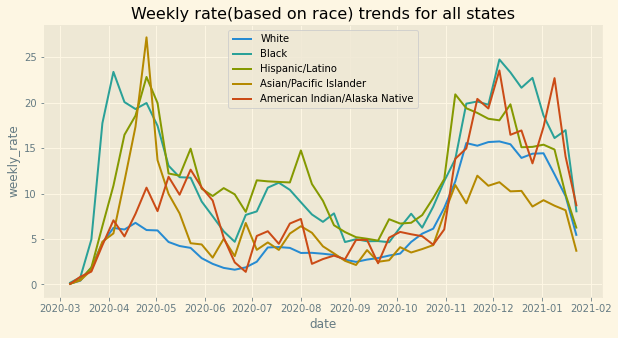

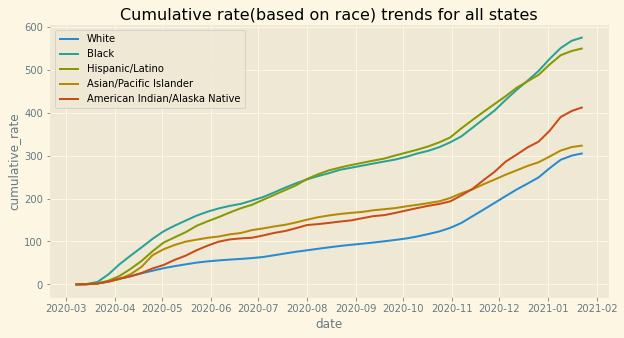

In [128]:
plt.figure(figsize=(10,5))
plt.title('Weekly rate(based on race) trends for all states')
sns.lineplot(data=race_df, x='date', y='weekly_rate', hue='race', err_style=None)
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,5))
plt.title('Cumulative rate(based on race) trends for all states')
sns.lineplot(data=race_df, x='date', y='cumulative_rate', hue='race', err_style=None)
plt.legend(loc='best')
plt.show()

### Hospitalization rate (based on age)

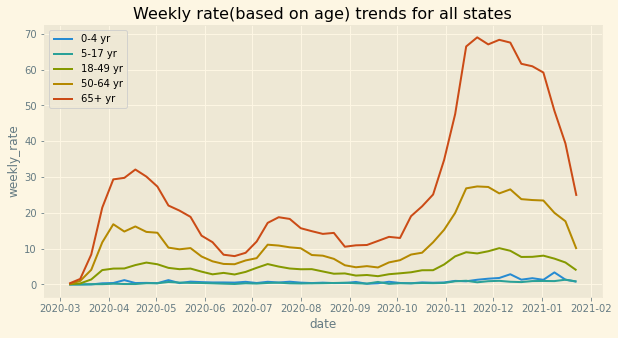

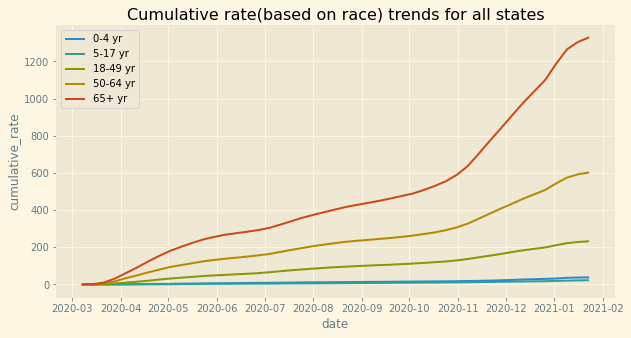

In [129]:
plt.figure(figsize=(10,5))
plt.title('Weekly rate(based on age) trends for all states')
sns.lineplot(data=age_df, x='date', y='weekly_rate', hue='age_category', err_style=None)
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,5))
plt.title('Cumulative rate(based on race) trends for all states')
sns.lineplot(data=age_df, x='date', y='cumulative_rate', hue='age_category', err_style=None)
plt.legend(loc='best')
plt.show()